## Leistungsnachweis 2, CDS1011_LN2
Erprobung von verschiedenen Machine-Learning Modellen, zur Ermittlung vom Körperfett

In [27]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

np.random.seed(42)



# Importieren und Anpassungen der Daten
Da alle Daten ausser die Grösse ('Height') und das Gewicht ('Weight') im metrischen Mass sind, wurden diese beiden Spalten auch noch auf das metrische Mass gewandelt.

In [28]:
usedCols = ["Weight", "Height", "Neck", "Chest", "Abdomen", "Hip", "Thigh", "Knee", "Ankle", "Biceps", "Forearm", "Wrist", "class"]     # Die Spalte 'Age' wurde bewusst entfernt, da bei den Tests erkannt wurde, dass diese einen negativen Einfluss auf das Lineare Regressionsmodell und womöglich auch auf das Random Forest Modell hat.
dataset = pd.read_csv("../dataset/Testdata.csv", usecols=usedCols)

height = dataset[["Height"]].values
weight = dataset[["Weight"]].values

# Anpassung der Daten "Height" und "Weight" auf das Metrische Masssystem
for index in range(len(weight)):
    height[index] = height[index] * 2.54        
    weight[index] = weight[index] * 0.454

dataset[["Height"]] = height
dataset[["Weight"]] = weight
dataset


,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,class
0,70.0295,172.085,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,12.3
1,78.6555,183.515,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,6.1
2,69.9160,168.275,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,25.3
3,83.8765,183.515,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,10.4
4,83.6495,180.975,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,28.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,60.9495,170.180,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5,11.0
241,91.2540,177.165,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1,33.6
242,84.7845,167.640,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0,29.3
243,86.6005,179.070,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8,26.0


Überprüfen ob es irgendeine Zelle ohne einen Wert gibt.

In [29]:
dataset.isnull().sum()

Weight     0
Height     0
Neck       0
Chest      0
Abdomen    0
Hip        0
Thigh      0
Knee       0
Ankle      0
Biceps     0
Forearm    0
Wrist      0
class      0
dtype: int64

Für alle vorhandenen Attribute einen Scatterplot erstellen, um kurz zu prüfen ob es bei irgendeinem der Werte einen Ausreisser gibt. <br>
Die gefundenen Ausreisser wurden im Anschluss aus dem Datensatz entfernt.

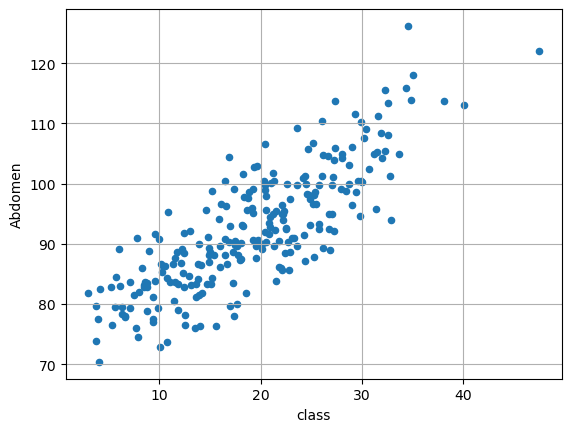

In [30]:
dataset.plot(kind="scatter", x="class", y="Abdomen", grid=True)
plt.show()

Mithilfe einer Heatmap jegliche Korreleationen zwischen den Werten darstellen lassen

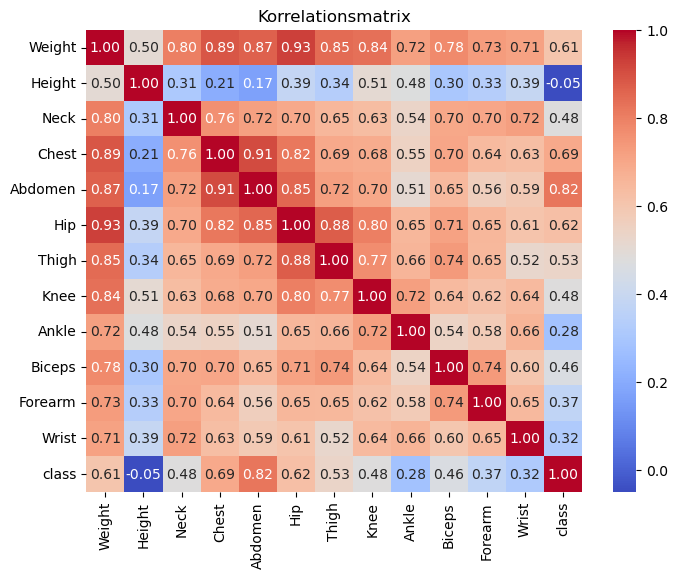

In [31]:
import seaborn as sns

# Beispiel-Daten
df = pd.DataFrame(dataset)

# Korrelationsmatrix berechnen
corr_matrix = df.corr()

# Heatmap zeichnen
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korrelationsmatrix")
plt.show()


Die am meisten korrelierenden Features in einer Scatter Matrix darstellen, um sich einen besseren Überblick zu verschaffen und mögliche Muster zu erkennen.


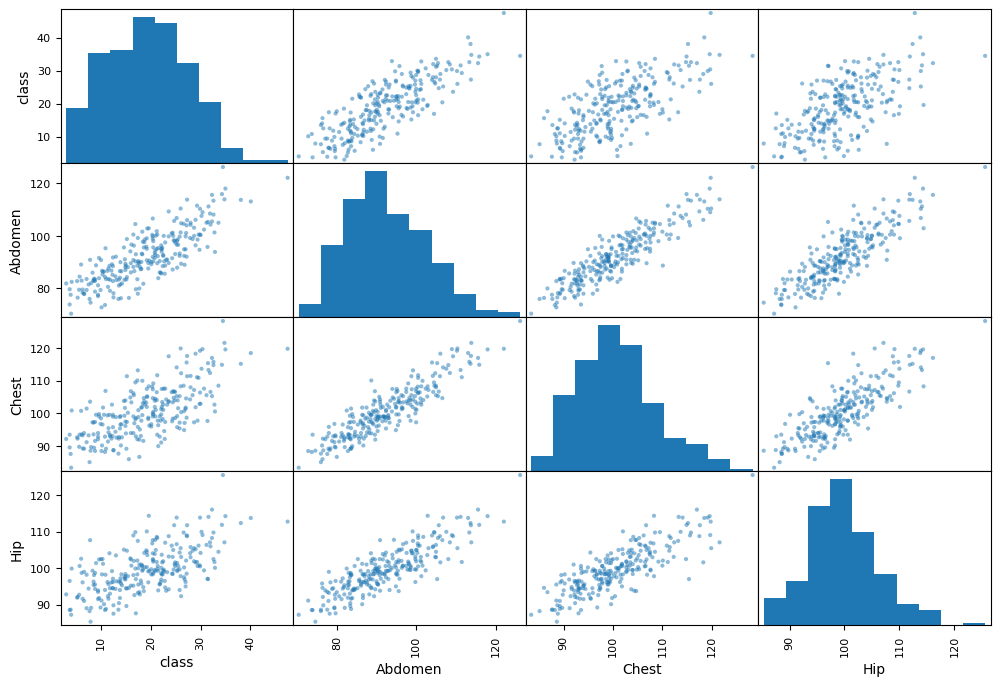

In [32]:
from pandas.plotting import scatter_matrix

attributes = ["class", "Abdomen", "Chest",
              "Hip"]
scatter_matrix(dataset[attributes], figsize=(12, 8))
plt.show()

# Wahl und testen der Modelle
Wir entschieden uns für folgende drei Machine-Learning Modelle:
- Linear Regression
- Decision Tree Regressor
- Random Forest Regressor

Wir trafen diese Auswahl, da diese 3 Modelle die uns aktuell am geläufigsten sind und wir noch nicht wirklich andere kennengelernt haben.

# Erstes Training
Für das erste Training der Modelle, entschieden wir uns, alle vorhandenen Features zu verwenden. <br>
Grund dafür war, dass wir in unserem Datensatz mit 13 Features, über eine relativ kleine Menge an Merkmalen verfügten und wir zu Beginn die Genauigkeit der verschiedenen Modelle ohne weitere Anpassungen vergleichen wollten.

Innerhalb der Pipeline wurde mit einem prepocessor gearbeitet, um alle Spalten auf eine ähnliche Skala zu bringen und dadurch die Effektivität der Modelle zu verbessern.

Beim Random Forest Regressor wurde definiert, dass alle Features verwendet werden sollen.

Im Anschluss wurde der Datensatz noch in einen Trainings- und Testdatenstaz gewandelt. <br>
Dies in einer Ratio von 80/20, d.h. wir haben ca. 200 Trainingswerte und ca. 50 Testwerte

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# Daten vorbereiten
X = dataset[["Weight", "Height", "Neck", "Chest", "Abdomen", "Hip", "Thigh", "Knee", "Ankle", "Biceps", "Forearm", "Wrist"]]
Y = dataset['class']

# Transformationen definieren
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ["Weight", "Height", "Neck", "Chest", "Abdomen", "Hip", "Thigh", "Knee", "Ankle", "Biceps", "Forearm", "Wrist"]),
])

# Pipeline erstellen
pipelineLinear = Pipeline([
    ('prep', preprocessor),
    ('model', LinearRegression())
])

pipelineDecisionTree = Pipeline([
    ('prep', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

pipelineForest = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestRegressor (n_estimators=200, max_features=13, random_state=42))
])

# Training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
pipelineLinear.fit(X_train, Y_train)
pipelineDecisionTree.fit(X_train, Y_train)
pipelineForest.fit(X_train, Y_train)


# Vorhersage
y_predLinear = pipelineLinear.predict(X_train)
y_predDecisionTree = pipelineDecisionTree.predict(X_train)
y_predForest = pipelineForest.predict(X_train)




# Vergleich der Genauigkeit der verschiedenen Modelle

Im Anschluss wurde von jedem Modell der RMSE Wert ermittelt, um einen groben Überblick zu erhalten, wie die einzelnen Modelle ohne Anpassungen abschneiden.

Anhand der erhaltenen Werte, kamen wir zum Schluss, dass die beiden Modelle **'Linear Regressior'** und **'Random Forest Regressior'** eine ähnliche Genauigkeit aufweisen, während das Modell **'Decision Tree Regressor'** deutlich schlechter Abschnitt.

Aus diesen Erkenntnis entschieden wir, dass wir uns für dieses Projekt auf die folgenden beiden Modelle fokussieren möchten:
- Linear Regressor
- Random Forest Regressor

In [34]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(pipelineDecisionTree, X_train, Y_train,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(tree_rmses).describe()

count    10.000000
mean      7.208281
std       1.554576
min       3.570784
25%       6.600991
50%       7.718912
75%       8.173786
max       8.793947
dtype: float64

In [35]:
lin_rmses = -cross_val_score(pipelineLinear, X_train, Y_train,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count    10.000000
mean      4.546085
std       0.608459
min       3.394777
25%       4.258184
50%       4.480430
75%       4.820451
max       5.700856
dtype: float64

In [36]:
forest_rmses = -cross_val_score(pipelineForest, X_train, Y_train,
                                scoring="neg_root_mean_squared_error", cv=10)
pd.Series(forest_rmses).describe()

count    10.000000
mean      4.914740
std       0.864563
min       2.770122
25%       4.711431
50%       5.133862
75%       5.336696
max       6.061010
dtype: float64

# Optimierung der einzelnen Modelle
Nachdem die Auswahl auf 2 Modelle getroffen wurde, war das Ziel diese zu optimieren und zu verbessern.
Da bisher mit allen Features gearbeitet wurde, lag das erste Ziel darin, die besten Features (Höchster Einfluss auf das Resultat) zu ermitteln, um allfälige Features, welche einen Negativen Einfluss haben, zu eliminieren.

### Wichtigste Features: Random Forest Regressor
Beim Random Forest Regressor wurde dafür ein GridSearch durchgeführt, aus welchem im Anschluss die besten Features entnommen wurden.
Diese wurden in einem Plot visualisiert.

In [37]:
from sklearn.model_selection import GridSearchCV

# Transformationen definieren
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ["Weight", "Height", "Neck", "Chest", "Abdomen", "Hip", "Thigh", "Knee", "Ankle", "Biceps", "Forearm", "Wrist"]),
])

full_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'random_forest__max_features': [1,3,5,7,9,11,13],  # Optimierung der Featureanzahl für RF
     'random_forest__n_estimators': [50, 100, 200]},  # Anzahl der Bäume im Wald
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=10,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Weight',
                                                                          'Height',
                                                                          'Neck',
                                                                          'Chest',
                                                                          'Abdomen',
                                                                          'Hip',
                                                                          'Thigh',
                                                                          'Knee',
                                                                          'Ankle',
                                                                          'Biceps',
                                                                          'Forearm',
                                                                          'Wrist'])])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'random_forest__max_features': [1, 3, 5, 7, 9, 11,
                                                          13],
                          'random_forest__n_estimators': [50, 100, 200]}],
             scoring='neg_root_mean_squared_error')

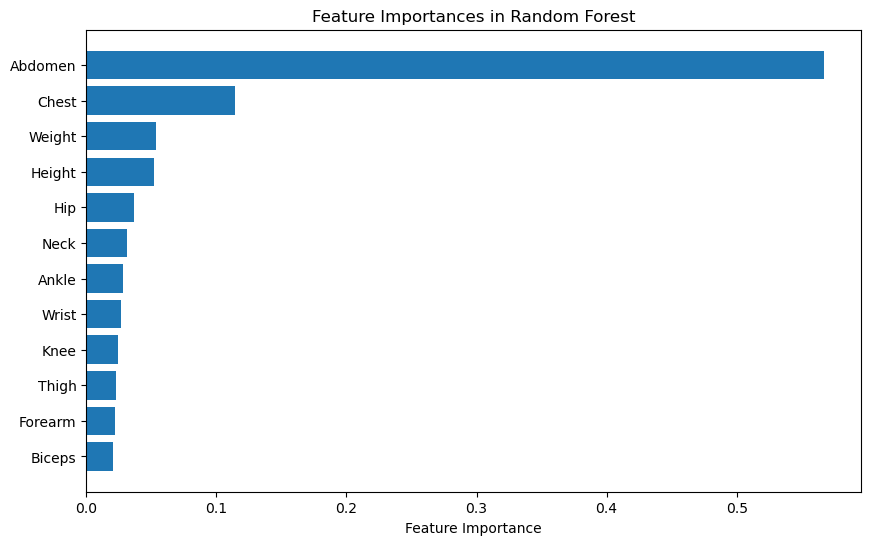

In [38]:
best_model = grid_search.best_estimator_                # Das beste Modell der Grid-Search entnehmen

# Die Feature Importances entnehmen
rf_model = best_model.named_steps['random_forest']      
importances = rf_model.feature_importances_

feature_names = ["Weight", "Height", "Neck", "Chest", "Abdomen", "Hip", 
                 "Thigh", "Knee", "Ankle", "Biceps", "Forearm", "Wrist"]

# Sortieren der Features nach Wichtigkeit
sorted_indices = np.argsort(importances)[::-1]
sorted_features = [(feature_names[i], importances[i]) for i in sorted_indices]

# Sortieren für bessere Darstellung
sorted_features, sorted_importances = zip(*sorted_features)

# Visualisieren der Importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importances in Random Forest')
plt.gca().invert_yaxis()
plt.show()

# Wichtigste Features Linear Regression
Im Linearen Regressionsmodell konnten die Koeffizienten direkt aus dem Modell entnommen werden, ohne das ein GridSearch durchgeführt werden musste.
Im Anschluss wurden auch hier die Features nach Importance sortiert. Da die Spaltennamen vom Preprocessor angepasst wurden, wurde hier mit den neuen Spaltennamen gearbeitet, um Missinterpretationen zu vermeiden.

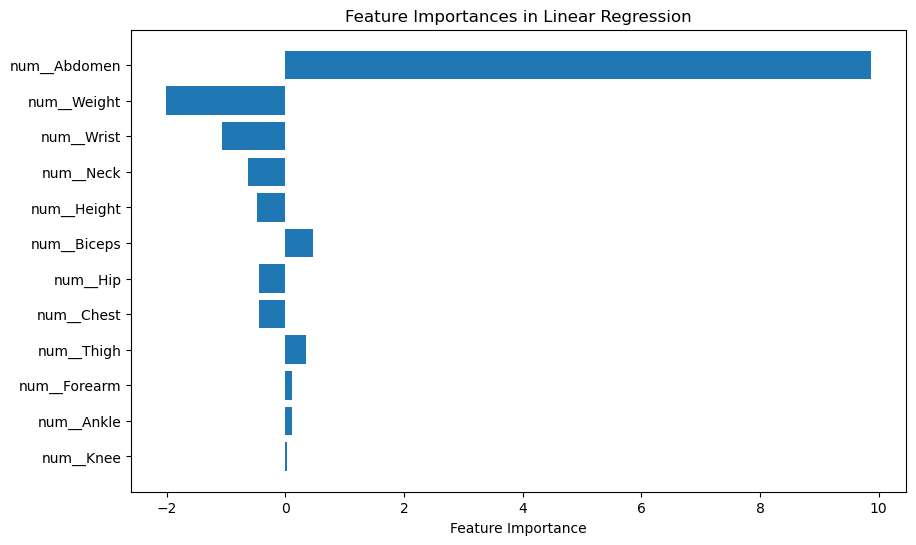

In [39]:
linearCoefficents = pipelineLinear.named_steps['model'].coef_
transformed_feature_names = pipelineLinear.named_steps['prep'].get_feature_names_out()

feature_importance = list(zip(transformed_feature_names, linearCoefficents))

# Sortieren nach Absolutwert der Koeffizienten
sorted_features = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

# Sortieren für bessere Darstellung
sorted_features, sorted_importances = zip(*sorted_features)
top_features_rf = [feature for feature, importance in feature_importance[:5]]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importances in Linear Regression')
plt.gca().invert_yaxis()
plt.show()


# Ermitteln der wichtigsten Features Modell-Übergreifend.
Da wir am Ende beide Modelle zusammen verwenden wollen, sollten beide Modelle die gleichen Features verwenden.
Um das beste von beiden Modellen zu erhalten, wurden die Features mit dem grössten Einfluss beider Modelle zusammengeführt.
Es wurde mit verschiedenen Anzahl Features pro Modell experimentiert.
Die Verwendung von den 4 Top-Features pro Modell ergaben das beste Ergebnis.

In [40]:

# Feature-Namen nach Preprocessing


# Verknüpfen und Sortieren nach Wichtigkeit
rf_feature_importance = list(zip(feature_names, importances))
rf_feature_importance = sorted(rf_feature_importance, key=lambda x: x[1], reverse=True)

# Extrahieren der Top-Features (Anz. 4)
top_features_rf = [feature for feature, importance in rf_feature_importance[:4]]
print("Top-Features aus Random Forest:", top_features_rf)


Top-Features aus Random Forest: ['Abdomen', 'Chest', 'Weight', 'Height']


In [41]:
# Koeffizienten der linearen Regression
lr_model = pipelineLinear.named_steps['model']
lr_coefficients = lr_model.coef_

# Feature-Namen nach Preprocessing
lr_feature_names = pipelineLinear.named_steps['prep'].get_feature_names_out()
# num__ aus den Feature Namen löschen
for index in range(len(lr_feature_names)):
    lr_feature_names[index] = lr_feature_names[index][5:]

# Verknüpfen und Sortieren nach Absolutwert der Koeffizienten
lr_feature_importance = list(zip(lr_feature_names, lr_coefficients))
lr_feature_importance = sorted(lr_feature_importance, key=lambda x: abs(x[1]), reverse=True)

# Extrahieren der Top-Features (Anz. 4)
top_features_lr = [feature for feature, coef in lr_feature_importance[:4]]
print("Top-Features aus Linear Regression:", top_features_lr)


Top-Features aus Linear Regression: ['Abdomen', 'Weight', 'Wrist', 'Neck']


In [42]:
# Schnittmenge (gemeinsame Features)
common_features = list(set(top_features_rf).intersection(set(top_features_lr)))
print("Gemeinsame Features:", common_features)

# Kombination der Top-Features aus beiden Modellen (ohne Duplikate)
final_features = list(set(top_features_rf + top_features_lr))
print("Finale Features:", final_features)


Gemeinsame Features: ['Abdomen', 'Weight']
Finale Features: ['Abdomen', 'Weight', 'Wrist', 'Neck', 'Height', 'Chest']


# Erstellen der Finalen Modelle

Nachdem nun die Features, welche verwendet werden sollen, identifiziert waren, wurden die beiden MLM neu erstellt.
Folgende Features werden nun Final verwendet:
- Wrist
- Weight
- Height
- Chest
- Abdomen

Es wird ebenfalls ein neuer Trainings- und Testdatensatz erstellt, welcher nur jene Features enthält.

In [43]:
# Daten vorbereiten
X_final = dataset[final_features]
Y_final = dataset['class']
max_features = len(final_features)
# Transformationen definieren
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), final_features),
])

# Pipeline erstellen
finalPipelineLinear = Pipeline([
    ('prep', preprocessor),
    ('model', LinearRegression())
])

finalPipelineForest = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestRegressor (n_estimators=200, max_features=max_features, random_state=42))
])

# Training
X_train_final, X_test_final, Y_train_final, Y_test_final = train_test_split(X_final, Y_final, test_size=0.2, random_state=42)
finalPipelineLinear.fit(X_train_final, Y_train_final)
finalPipelineForest.fit(X_train_final, Y_train_final)



Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Abdomen', 'Weight', 'Wrist',
                                                   'Neck', 'Height',
                                                   'Chest'])])),
                ('model',
                 RandomForestRegressor(max_features=6, n_estimators=200,
                                       random_state=42))])

In [44]:
lin_rmses = -cross_val_score(finalPipelineLinear, X_train_final, Y_train_final,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count    10.000000
mean      4.374831
std       0.601815
min       3.172262
25%       4.204354
50%       4.304171
75%       4.688644
max       5.478272
dtype: float64

In [45]:
rf_rmses = -cross_val_score(finalPipelineForest, X_train_final, Y_train_final,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(rf_rmses).describe()

count    10.000000
mean      4.864759
std       0.809921
min       2.895458
25%       4.638100
50%       5.009877
75%       5.407263
max       5.743278
dtype: float64

# Hyperparameter Random Forest Regressor
Beim Random Forest Regressor können nun noch die optimalen Hyperparameter ermittelt werden.
Dabei beschränkten wir uns auf folgende Parameter:
- Anzahl Features
- Anzahl Bäume im Wald

In [46]:
param_grid = {
    'model__n_estimators': [100, 200, 300, 400, 500],
    'model__max_features': [3,4, 5, 6, 7],
    
}
grid_search = GridSearchCV(finalPipelineForest, param_grid, cv=10, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_final, Y_train_final)

print("Beste Parameter:", grid_search.best_params_)
print("Beste R2-Score:", grid_search.best_score_)


Beste Parameter: {'model__max_features': 6, 'model__n_estimators': 200}
Beste R2-Score: 0.6232593025025349


Mit diesen ermittelten Besten Hyperparametern, wurde im Anschluss das Random Forest Modell neu erstellt und trainiert.



In [47]:
finalPipelineForest = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestRegressor (n_estimators=100, max_features=4, random_state=42))    # Bei den Finalen Tests wurde festgestellt, dass das Modell einiges besser funktioniert, wenn max_features = 4 ist, und nicht wie von Gridsearch ermittelt 5.
])

# Training
finalPipelineForest.fit(X_train_final, Y_train_final)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Abdomen', 'Weight', 'Wrist',
                                                   'Neck', 'Height',
                                                   'Chest'])])),
                ('model',
                 RandomForestRegressor(max_features=4, random_state=42))])

# Austesten der Modelle
Nun, da die Modelle modifiziert und optimiert wurden, war die Zeit gekommen, die Modelle mit dem Testdatensatz auf ihre Genauigkeit zu überprüfen.
Im Anschluss wurde jeweils der MSE und R2 Wert der einzelnen Modelle ermittelt.

Die Resultate waren zufriedenstellend.

In [48]:
from sklearn.metrics import mean_squared_error, r2_score

# Lineares Modell
y_test_pred_linear = finalPipelineLinear.predict(X_test_final)
print("Linear Regression - MSE:", mean_squared_error(Y_test_final, y_test_pred_linear))
print("Linear Regression - R2:", r2_score(Y_test_final, y_test_pred_linear))

# Random Forest
y_test_pred_forest = finalPipelineForest.predict(X_test_final)
print("Random Forest - MSE:", mean_squared_error(Y_test_final, y_test_pred_forest))
print("Random Forest - R2:", r2_score(Y_test_final, y_test_pred_forest))


Linear Regression - MSE: 15.740676649146538
Linear Regression - R2: 0.7175970987601767
Random Forest - MSE: 13.580071244897955
Random Forest - R2: 0.7563604409083254


# Residuenanalyse
Um zu überprüfen ob das Linear Regression Modell nicht overfitted ist oder vergleichbare Probleme aufweist, wurde eine Residuenanalyse durchgeführt.
Wir konnten auf der Visualisierung keine wirklichen Muster erkennen und die Ergebnisse waren gut verteilt, was zum Rückschluss führte, dass das Lineare Regressionsmodell vertrauenswürdig ist.

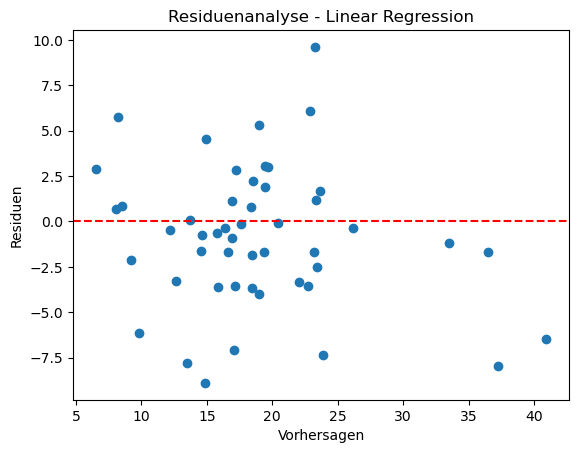

In [49]:
residuals = Y_test_final - y_test_pred_linear
plt.scatter(y_test_pred_linear, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Vorhersagen")
plt.ylabel("Residuen")
plt.title("Residuenanalyse - Linear Regression")
plt.show()

# Verknüpfung der beiden Modelle
Nun werden die beiden Modelle verknüpft.
Wir entschieden uns für die simple Methode: "Weighed Averaging".
Diese sollte für unsere Anforderungen ausreichen.

Um die optimale Gewichtsverteilung der beiden Modelle zu ermitteln, wurde mit dem minimizer von Scipy gearbeitet.

Da das Random Forest Modell um einiges besser optimiert werden konnte als das Linear Regression Modell, ist die Gewichtsverteilung relativ unausgeglichen.

In [50]:
from scipy.optimize import minimize

# Vorhersagen der Modelle
y_pred_linear = finalPipelineLinear.predict(X_test_final)
y_pred_forest = finalPipelineForest.predict(X_test_final)

# Zielfunktion: MSE minimieren
def objective(weights):
    w_linear, w_forest = weights
    y_pred_combined = w_linear * y_pred_linear + w_forest * y_pred_forest
    return mean_squared_error(Y_test_final, y_pred_combined)

# Nebenbedingungen: Die Gewichte müssen summiert 1 ergeben
constraints = {'type': 'eq', 'fun': lambda w: w[0] + w[1] - 1}
bounds = [(0, 1), (0, 1)]  # Gewichte müssen zwischen 0 und 1 liegen

# Startwerte für die Optimierung
initial_weights = [0.5, 0.5]

# Optimierung durchführen
result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)

# Optimale Gewichte und MSE
best_weights = result.x
best_mse = result.fun

print("Optimale Gewichte:", best_weights)
print("MSE mit optimalen Gewichten:", best_mse)


Optimale Gewichte: [0.21405747 0.78594253]
MSE mit optimalen Gewichten: 13.406957133427639


# Erneuter Test
Nun, nachdem die optimalen Gewichte ermittelt wurden, führten wir einen finalen Test durch, um nochmals den deifnitiven MSE & R2 Wert der beiden Modelle kombiniert zu prüfen.

In [51]:
# Vorhersagen der beiden Modelle
y_pred_linear = finalPipelineLinear.predict(X_test_final)
y_pred_forest = finalPipelineForest.predict(X_test_final)

# Gewichtetes Mittel
weight_linear = best_weights[0]      # Gewicht für Lineare Regression
weight_forest = best_weights[1]      # Gewicht für Random Forest

y_pred_combined = (weight_linear * y_pred_linear) + (weight_forest * y_pred_forest)

# Leistung bewerten
from sklearn.metrics import mean_squared_error, r2_score
mse_combined = mean_squared_error(Y_test_final, y_pred_combined)
r2_combined = r2_score(Y_test_final, y_pred_combined)

print("MSE (Combined):", mse_combined)
print("R2 (Combined):", r2_combined)



MSE (Combined): 13.406957133427639
R2 (Combined): 0.7594662748196916


# Finale Funktion

Mit der Funktion **'predictBodyFat** kann nun mit beliebigen Werten der Körperfettanteil anhand von diversen Körpermassen geschätzt werden.

In [26]:
def predictBodyFat(X):
    # Vorhersagen der beiden Modelle
    y_pred_linear = finalPipelineLinear.predict(X)
    y_pred_forest = finalPipelineForest.predict(X)

    # Gewichtetes Mittel
    weight_linear = best_weights[0]      # Gewicht für Lineare Regression
    weight_forest = best_weights[1]      # Gewicht für Random Forest

    y_pred_combined = (weight_linear * y_pred_linear) + (weight_forest * y_pred_forest)
    return y_pred_combined

